In [66]:
# the predicitons for the months of June, July and Aug 2024 is saved as predicitons.
# while the predicitons for the months of September, October and November 2024 is saved as final_predictions.

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [68]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [69]:
data = pd.read_csv('/content/cleaned.csv')

In [70]:
data.dtypes

,0
weekend_date,object
quantity,int64


In [71]:
data = data.rename(columns={'weekend_date': 'date'})
data['date'] = pd.to_datetime(data['date'])

In [72]:
train = data[data['date']<='2024-05-31'].copy()
test = data[data['date']>'2024-05-31'].copy()

In [73]:
print(len(train), len(test))

105 14


In [74]:
predictions = pd.DataFrame({
    'date': test['date'],
    'quantity': test['quantity']
})
predictions.reset_index(drop=True, inplace=True)

In [75]:
predictions

,date,quantity
0,2024-06-01,2306
1,2024-06-08,7492
2,2024-06-15,7257
3,2024-06-22,2325
4,2024-06-29,1551
5,2024-07-06,3492
6,2024-07-13,8716
7,2024-07-20,4530
8,2024-07-27,1731
9,2024-08-03,1656


In [76]:
data_ml = data.copy()

In [77]:
# feature engineering
# lagged features
data_ml['lag_1'] = data_ml['quantity'].shift(1)
data_ml['lag_2'] = data_ml['quantity'].shift(2)
data_ml['lag_3'] = data_ml['quantity'].shift(3)
data_ml['lag_4'] = data_ml['quantity'].shift(4)
data_ml['lag_5'] = data_ml['quantity'].shift(5)
data_ml['lag_6'] = data_ml['quantity'].shift(6)
data_ml['lag_7'] = data_ml['quantity'].shift(7)

# rolling statistics
data_ml['rolling_mean_4'] = data_ml['quantity'].shift(1).rolling(window=4).mean()
data_ml['rolling_mean_8'] = data_ml['quantity'].shift(1).rolling(window=8).mean()

data_ml['rolling_median_4'] = data_ml['quantity'].shift(1).rolling(window=4).median()
data_ml['rolling_median_8'] = data_ml['quantity'].shift(1).rolling(window=8).median()

# time based features
data_ml['year'] = data_ml['date'].dt.year
data_ml['month'] = data_ml['date'].dt.month

# drop rows with missing values
data_ml.dropna(inplace=True)

In [78]:
train = data_ml[data_ml['date']<='2024-05-31'].copy()
test = data_ml[data_ml['date']>'2024-05-31'].copy()

In [79]:
data_ml.columns

Index(['date', 'quantity', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'lag_7', 'rolling_mean_4', 'rolling_mean_8',
       'rolling_median_4', 'rolling_median_8', 'year', 'month'],
      dtype='object')

In [80]:
features = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'rolling_mean_4', 'rolling_mean_8','rolling_median_4', 'rolling_median_8', 'year', 'month']
target = 'quantity'

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [81]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.metrics import mean_squared_error, r2_score

In [82]:
!pip install xgboost
import xgboost as xgb

In [83]:
models = {
    'Random Forest': RandomForestRegressor(n_estimators=200, random_state=1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=1),
    'XGBoost': xgb.XGBRegressor(random_state=1)
}

In [84]:
results = {}
ml_predictions = {}
for name, model in models.items():
  print(f"Training {name}...")
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  ml_predictions[name] = y_pred

Training Random Forest...
Training Gradient Boosting...
Training XGBoost...


In [85]:
# greater the accuracy better is the model. closer to 1 means better.

In [86]:
ml_predictions = pd.DataFrame(ml_predictions)

In [87]:
predictions = pd.merge(predictions, ml_predictions, left_index=True, right_index=True)

In [88]:
predictions.head(2)

,date,quantity,Random Forest,Gradient Boosting,XGBoost
0,2024-06-01,2306,2290.935,2031.383156,2003.218872
1,2024-06-08,7492,3831.110,2996.227014,4861.388184


In [89]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

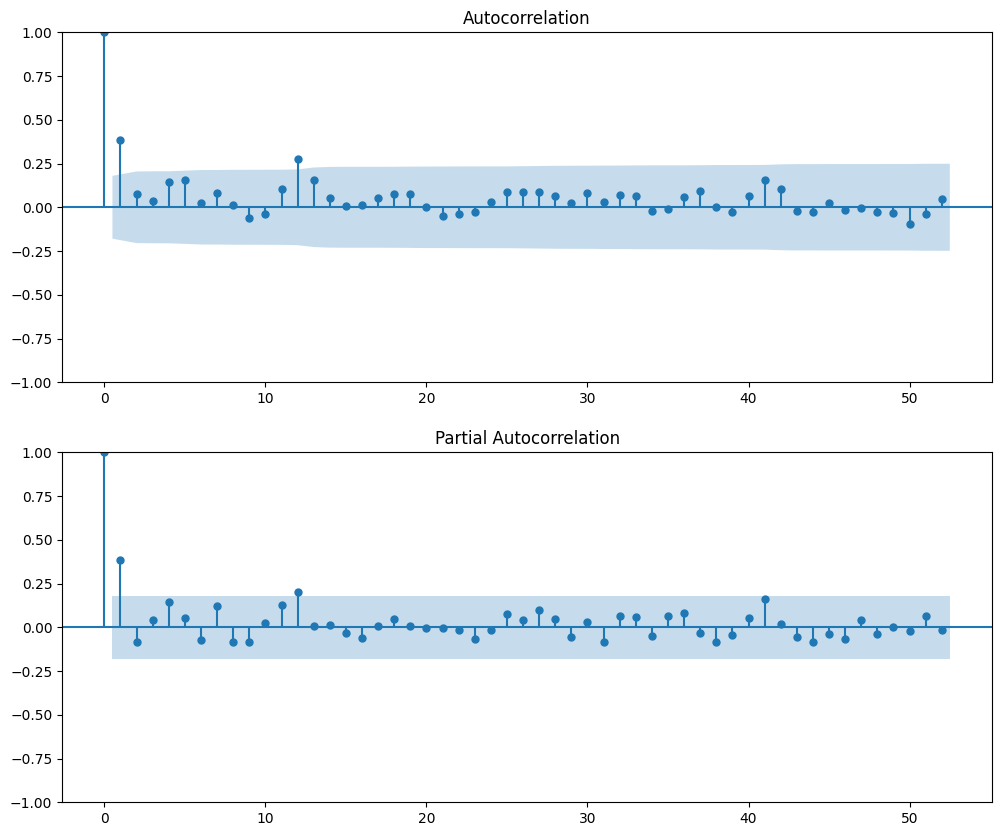

In [90]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(data['quantity'], ax=axes[0], lags=52)
plot_pacf(data['quantity'], ax=axes[1], lags=52)
plt.show()

In [91]:
from statsmodels.tsa.stattools import adfuller

In [92]:
adf_test_result = adfuller(data['quantity'])

# Print the ADF test results
print('ADF Statistic: %f' % adf_test_result[0])
print('p-value: %f' % adf_test_result[1])
print('Critical Values:')
for key, value in adf_test_result[4].items():
  print('\t%s: %.3f' % (key, value))

# Interpretation: If the p-value is less than the significance level (e.g., 0.05),
# we reject the null hypothesis and conclude that the series is stationary.


ADF Statistic: -7.218680
p-value: 0.000000
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580


In [93]:
adf_test_result = adfuller(data['quantity'].diff().dropna())

# Print the ADF test results
print('ADF Statistic: %f' % adf_test_result[0])
print('p-value: %f' % adf_test_result[1])
print('Critical Values:')
for key, value in adf_test_result[4].items():
  print('\t%s: %.3f' % (key, value))

# Interpretation: If the p-value is less than the significance level (e.g., 0.05),
# we reject the null hypothesis and conclude that the series is stationary.


ADF Statistic: -6.354714
p-value: 0.000000
Critical Values:
	1%: -3.493
	5%: -2.889
	10%: -2.581


In [94]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [95]:
Sarima = SARIMAX(train['quantity'], order=(1, 0, 1), seasonal_order=(1, 1, 1, 12)).fit()
# Sarima1 = SARIMAX(train['quantity'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [96]:
predictions['Sarima'] = Sarima.predict(start=len(train), end=len(train)+len(test)-1).reset_index(drop=True)
# predictions['Sarima1'] = Sarima1.predict(start=len(train), end=len(train)+len(test)-1).reset_index(drop=True)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [97]:
predictions.head(1)

,date,quantity,Random Forest,Gradient Boosting,XGBoost,Sarima
0,2024-06-01,2306,2290.935,2031.383156,2003.218872,3584.667932


In [98]:
predictions['Sarima+GB'] = pd.concat([predictions['Sarima'].head(9), predictions['Gradient Boosting'].tail(5)])

In [99]:
from prophet import Prophet

In [100]:
data_prophet = train.rename(columns={'date': 'ds', 'quantity': 'y'})
prophet_model = Prophet()
prophet_model.add_seasonality(name='12_week_seasonality', period=84, fourier_order=5)
prophet_model.fit(data_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwdr32eab/xwds844z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwdr32eab/wh1ds8xw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84925', 'data', 'file=/tmp/tmpwdr32eab/xwds844z.json', 'init=/tmp/tmpwdr32eab/wh1ds8xw.json', 'output', 'file=/tmp/tmpwdr32eab/prophet_modelnm0r8h0r/prophet_model-20250704084603.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
08:46:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:46:03 - cmdstanpy - INFO - Chai

In [101]:
future = prophet_model.make_future_dataframe(periods=14, freq='W-SAT')
forecast = prophet_model.predict(future)
predictions['Prophet'] = forecast[['yhat']].reset_index(drop=True)

In [102]:
predictions['Sarima+Prophet'] = pd.concat([predictions['Sarima'].head(9), predictions['Prophet'].tail(5)])

In [103]:
predictions['Combined_S+P'] = (.5*predictions['Sarima'] + .5*predictions['Prophet'])

In [104]:
def calculate_monthly_accuracy(df, date_col, y_actual_col, y_pred_col):
    # Copy to avoid modifying original
    df = df.copy()
    # Ensure datetime format
    df[date_col] = pd.to_datetime(df[date_col])
    # Create year_month column
    df['year_month'] = df[date_col].dt.to_period('M')

    # Calculate monthly accuracy
    monthly_accuracy = (
        df
        .groupby('year_month')
        .apply(lambda g: 1 - (np.abs(g[y_pred_col] - g[y_actual_col]).sum() / g[y_actual_col].sum()))
        .reset_index(name='Monthly_Accuracy')
    )
    return monthly_accuracy

In [105]:
Accuracy_Table = pd.DataFrame()

In [106]:
predictions.columns

Index(['date', 'quantity', 'Random Forest', 'Gradient Boosting', 'XGBoost',
       'Sarima', 'Sarima+GB', 'Prophet', 'Sarima+Prophet', 'Combined_S+P'],
      dtype='object')

In [107]:
cols = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'Sarima', 'Sarima+GB', 'Prophet', 'Sarima+Prophet', 'Combined_S+P']
for col in cols:
  monthly_accuracy = calculate_monthly_accuracy(predictions, 'date', 'quantity', col)
  Accuracy_Table[f'{col}'] = monthly_accuracy['Monthly_Accuracy']

/tmp/ipython-input-104-1791485047.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: 1 - (np.abs(g[y_pred_col] - g[y_actual_col]).sum() / g[y_actual_col].sum()))
/tmp/ipython-input-104-1791485047.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: 1 - (np.abs(g[y_pred_col] - g[y_actual_col]).sum() / g[y_actual_col].sum()))
/tmp/ipython-input-104-1791485047.py:13: Depreca

In [108]:
Accuracy_Table

,Random Forest,Gradient Boosting,XGBoost,Sarima,Sarima+GB,Prophet,Sarima+Prophet,Combined_S+P
0,0.553733,0.566613,0.631789,0.732298,0.732298,0.497107,0.732298,0.673376
1,0.520429,0.603157,0.531418,0.731399,0.731399,0.407020,0.731399,0.569209
2,0.557630,0.749190,0.536891,0.202669,0.749190,0.780171,0.780171,0.707433


In [109]:
Accuracy_Table.mean().sort_values(ascending=False)

,0
Sarima+Prophet,0.747956
Sarima+GB,0.737629
Combined_S+P,0.650006
Gradient Boosting,0.639653
XGBoost,0.566699
Prophet,0.561433
Sarima,0.555455
Random Forest,0.543931


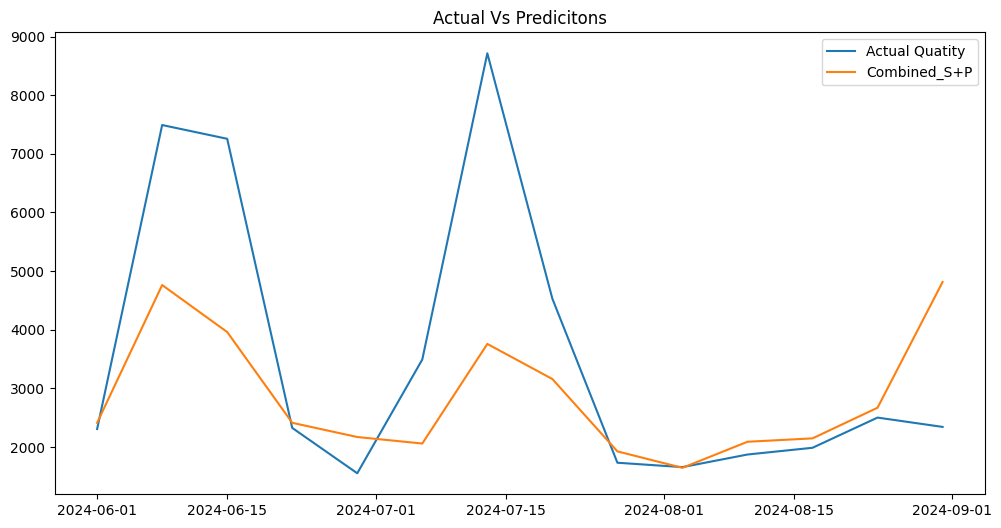

In [110]:
plt.figure(figsize=(12, 6))
# plt.plot(data['date'], data['quantity'], label='Original Data')
plt.plot(test['date'], predictions['quantity'], label='Actual Quatity')
# plt.plot(test['date'], predictions['Gradient Boosting'], label='Gradient Boosting')
# plt.plot(test['date'], predictions['XGBoost'], label='XGBoost')
# plt.plot(test['date'], predictions['Sarima'], label='Sarima')
# plt.plot(test['date'], predictions['Sarima+GB'], label='Sarima+GB')
# plt.plot(test['date'], predictions['Prophet'], label='Prophet')
# plt.plot(test['date'], predictions['Sarima+Prophet'], label='Sarima+Prophet')
plt.plot(test['date'], predictions['Combined_S+P'], label='Combined_S+P')
plt.legend()
plt.title('Actual Vs Predicitons')
plt.show()

In [111]:
start_date = data['date'].max()+pd.Timedelta(days=1)
end_date = start_date + pd.DateOffset(months=3)

future_dates = pd.date_range(start=start_date + pd.Timedelta(days=(5 - start_date.weekday()) % 7), end=end_date, freq='W-SAT')

# Create a DataFrame from the generated dates
final_predictions = pd.DataFrame({'date': future_dates})

In [112]:
# Sarima Model
final_sarima = SARIMAX(data['quantity'], order=(1, 0, 1), seasonal_order=(1, 1, 1, 12)).fit()

# Prophet Model
data_prophet = data.rename(columns={'date': 'ds', 'quantity': 'y'})
final_prophet_model = Prophet()
final_prophet_model.add_seasonality(name='12_week_seasonality', period=84, fourier_order=5)
final_prophet_model.fit(data_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwdr32eab/nd08cqxf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwdr32eab/0qnhx67l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41352', 'data', 'file=/tmp/tmpwdr32eab/nd08cqxf.json', 'init=/tmp/tmpwdr32eab/0qnhx67l.json', 'output', 'file=/tmp/tmpwdr32eab/prophet_modelqtbl_9hl/prophet_model-20250704084604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:46:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:46:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [113]:
# sarima predictions
sarima_forecast = Sarima.forecast(steps=13)
final_predictions['Sarima'] = sarima_forecast.reset_index(drop=True)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [114]:
# prophet predictions
future = final_prophet_model.make_future_dataframe(periods=len(final_predictions), freq='W-SAT')
forecast = final_prophet_model.predict(future)
final_predictions['Prophet'] = forecast.tail(len(final_predictions))['yhat'].reset_index(drop=True)

In [115]:
# combined predictions
final_predictions['Combined'] = (.5*final_predictions['Sarima'] + .5*final_predictions['Prophet'])

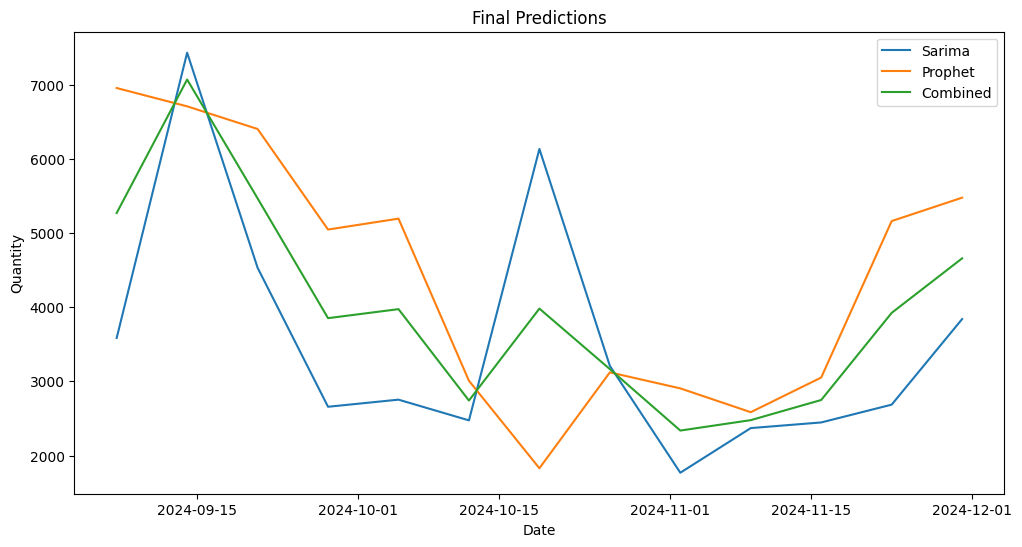

In [116]:
plt.figure(figsize=(12, 6))
plt.plot(final_predictions['date'], final_predictions['Sarima'], label='Sarima')
plt.plot(final_predictions['date'], final_predictions['Prophet'], label='Prophet')
plt.plot(final_predictions['date'], final_predictions['Combined'], label='Combined')
plt.legend()
plt.title('Final Predictions')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.show()

In [117]:
import joblib
import pickle

In [118]:
# Save SARIMA
joblib.dump(final_sarima, 'sarima_model.pkl')

# Save Prophet
with open('prophet_model.pkl', 'wb') as f:
    pickle.dump(final_prophet_model, f)

In [119]:
# Load SARIMA
sarima_model = joblib.load('sarima_model.pkl')

# Load Prophet
with open('prophet_model.pkl', 'rb') as f:
    prophet_model = pickle.load(f)

In [120]:
# # SARIMA prediction
# sarima_forecast = sarima_model.forecast(steps=n)

# # Prophet prediction
# future = prophet_model.make_future_dataframe(periods=n, freq='W-SAT')
# prophet_forecast = prophet_model.predict(future)
# prophet_pred = prophet_forecast.tail(n)['yhat'].values

# # Individual forecasts
# sarima_forecast
# prophet_pred

# # Final blended prediction
# final_pred = 0.5 * sarima_forecast + 0.5 * prophet_pred

In [121]:
# predicitons of the month of June, July and Aug 2024
predictions

,date,quantity,Random Forest,Gradient Boosting,XGBoost,Sarima,Sarima+GB,Prophet,Sarima+Prophet,Combined_S+P
0,2024-06-01,2306,2290.935,2031.383156,2003.218872,3584.667932,3584.667932,1236.785522,3584.667932,2410.726727
1,2024-06-08,7492,3831.110,2996.227014,4861.388184,7428.545249,7428.545249,2095.953665,7428.545249,4762.249457
2,2024-06-15,7257,4802.200,5726.842808,4934.036133,4531.459662,4531.459662,3389.775755,4531.459662,3960.617709
3,2024-06-22,2325,3933.000,3472.028602,3676.198242,2657.843596,2657.843596,2166.114766,2657.843596,2411.979181
4,2024-06-29,1551,3153.070,3174.646815,2650.477051,2753.761719,2753.761719,1585.679110,2753.761719,2169.720415
5,2024-07-06,3492,2644.225,2834.188519,3829.164307,2474.536978,2474.536978,1642.153111,2474.536978,2058.345044
6,2024-07-13,8716,2807.695,2898.898984,1757.482910,6131.789852,6131.789852,1383.820425,6131.789852,3757.805139
7,2024-07-20,4530,4094.340,5261.084422,3401.122314,3209.014508,3209.014508,3109.166136,3209.014508,3159.090322
8,2024-07-27,1731,3396.455,1854.305174,1960.682861,1769.139420,1769.139420,2079.889037,1769.139420,1924.514229
9,2024-08-03,1656,2455.900,1613.177146,2151.520020,2370.563509,1613.177146,917.567472,917.567472,1644.065490


In [122]:
Accuracy_Table

,Random Forest,Gradient Boosting,XGBoost,Sarima,Sarima+GB,Prophet,Sarima+Prophet,Combined_S+P
0,0.553733,0.566613,0.631789,0.732298,0.732298,0.497107,0.732298,0.673376
1,0.520429,0.603157,0.531418,0.731399,0.731399,0.407020,0.731399,0.569209
2,0.557630,0.749190,0.536891,0.202669,0.749190,0.780171,0.780171,0.707433


In [124]:
Accuracy_Table.mean().sort_values(ascending=False)

,0
Sarima+Prophet,0.747956
Sarima+GB,0.737629
Combined_S+P,0.650006
Gradient Boosting,0.639653
XGBoost,0.566699
Prophet,0.561433
Sarima,0.555455
Random Forest,0.543931


In [123]:
# predicitons of the month of September, October and November 2024
final_predictions

,date,Sarima,Prophet,Combined
0,2024-09-07,3584.667932,6952.773280,5268.720606
1,2024-09-14,7428.545249,6705.997125,7067.271187
2,2024-09-21,4531.459662,6400.844319,5466.151991
3,2024-09-28,2657.843596,5045.913440,3851.878518
4,2024-10-05,2753.761719,5192.834630,3973.298175
5,2024-10-12,2474.536978,3008.296095,2741.416536
6,2024-10-19,6131.789852,1829.440089,3980.614971
7,2024-10-26,3209.014508,3121.394264,3165.204386
8,2024-11-02,1769.139420,2905.553171,2337.346296
9,2024-11-09,2370.563509,2584.740707,2477.652108
